<a href="https://colab.research.google.com/github/NHirt32/LLM-News-Digest/blob/dev/API_LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Setup

Setting up the environment with required imports and installations


In [29]:
!pip install python-dotenv
!pip install openai
!pip install jupyter-ui-poll

In [71]:
# For API requests
import requests
# For mounting files and securing sensitive data
from google.colab import drive
import os
from dotenv import load_dotenv
# For OpenAI requests
import openai
# For interactive UI
import ipywidgets as widgets
from IPython.display import display
import time
from jupyter_ui_poll import ui_events
# For string processing
import re
# For data visualization
import matplotlib.pyplot as plt

Here I'm mounting a .env file to prevent sharing my API key on my GitHub repository.

In [31]:
drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/API-LLM-Project/.env'
load_dotenv(env_path)
news_key = os.getenv("NEWS_API_KEY")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# News API Setup

Getting user input about desired country.

In [32]:
# Define the dropdown widget with a placeholder option
country_dropdown = widgets.Dropdown(
    options=[
        ('Select a Country', 'select'),
        ('United States', 'US'),
        ('United Kingdom', 'GB'),
        ('Canada', 'CA'),
        ('Australia', 'AU'),
        ('Germany', 'DE'),
        ('France', 'FR'),
    ],
    value='select',  # default value
    description='Country:',
)

display(country_dropdown)

# Essentially a loop that will alternate between polling ui events and sleeping until the user makes a selection
with ui_events() as poll:
  while country_dropdown.value == 'select':
    poll(10)
    time.sleep(0.1)

Dropdown(description='Country:', options=(('Select a Country', 'select'), ('United States', 'US'), ('United Ki…

Setting up API parameters

In [33]:
# Top URLs syntax: url?country={chosen_country}&apiKey=API_KEY
top_headlines_url = 'https://newsapi.org/v2/top-headlines'
temp_country = country_dropdown.value
news_params = {
    'country': temp_country,
    'apiKey': news_key
}

Here, we retrieve a response from the News API. If an error occurs, we halt the execution of the notebook; otherwise, we combine the titles and descriptions into a single, readable string to provide to our LLM.

In [34]:
news_response = requests.get(top_headlines_url, params = news_params)
# If the response from News API is not "OK" stop the execution of the project
if news_response.status_code != 200:
  raise RuntimeError(f"Error: {news_response.status_code}, {news_response.reason}")
# Converting request object to dictionary
news_data = news_response.json()
# Now we combine all titles and descriptions into a single legible string
combined_content = '\n\n'.join(
    f"Title: {article['title']} \n Description{article['description']}"
    for article in news_data['articles']
)

# OpenAI API Setup

Here we setup our OpenAI API parameters.

In [65]:
openai.api_key = os.getenv("OPENAI_API_KEY")
openai_params = {
    'model': 'gpt-4o',
    'messages': [
        {
            "role": "system",
            "content": (
                "You are an intelligent summarization assistant tasked with categorizing news articles into the specific sections: 'Politics', 'Economics', 'Social Issues', 'Environment', 'Technology', and 'Entertainment.' "
                "Each category should have a single numeric percentage assigned (e.g., 'Politics: 40%'). "
                "For each section with content, provide up to 3 bullet points summarizing the top 3 most relevant articles in that category. "
                "List articles as bullet points, using the format: '[Article Title] - [Source]: [Brief Summary]'. "
                "If a category has no articles, list it with a percentage of 0% and write 'No articles fit this category.' "
                "Do **not** create any categories other than 'Politics', 'Economics', 'Social Issues', 'Environment', 'Technology', and 'Entertainment.' "
                "Disregard content about weather, natural disasters, or other topics outside these specific categories, and do not create a 'Weather' category.\n\n"
                "Strictly follow this format for each response:\n\n"
                "- **Category Name: Percentage%**\n  1. Article Summary Bullet 1\n  2. Article Summary Bullet 2\n  3. Article Summary Bullet 3\n\n"
                "Example format:\n\n"
                "- **Politics: 40%**\n  1. Article Summary 1\n  2. Article Summary 2\n  3. Article Summary 3\n\n"
                "- **Economics: 20%**\n  No articles fit this category.\n\n"
                "Each response should include all categories listed, with clear headings, percentages, and article summaries as instructed."
            )
        },
        {
            "role": "user",
            "content": (
                f"Analyze the following articles and categorize them appropriately in the format specified. "
                f"The content is as follows:\n\n{combined_content}"
            )
        }
    ],
    'max_tokens': 1000,
    'temperature': 0  # Set temperature to 0 for deterministic responses
}

Now using our API parameters we make a request to OpenAI to summarize the combined content of our News API data.

In [66]:
try:
  openai_response = openai.chat.completions.create(**openai_params)
  # article_summary = openai_response.choices[0].message.content.strip()
  # print(f"Summary of Articles: {article_summary}")
except Exception as e:
  print(f"An error occured: {e}")
article_summary = openai_response.choices[0].message.content.strip()

# Data Visualization and Presentation

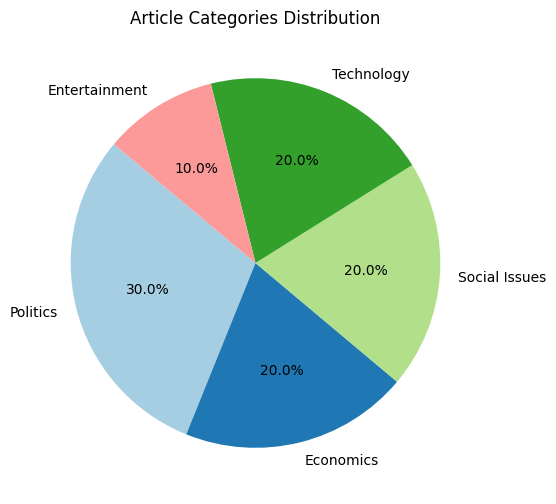

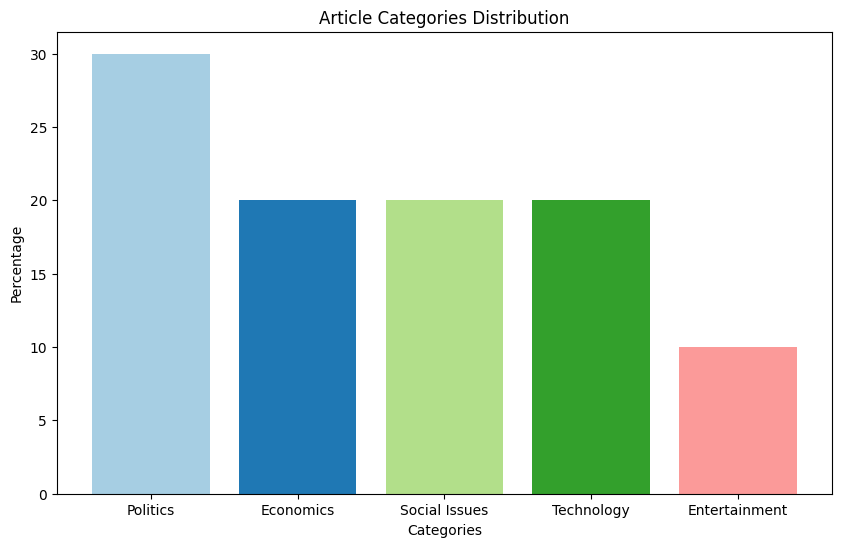

In [75]:
# Creating a regex to make a dictionary of the percentage breakdown of article varieties
category_matches = re.findall(r"-\s\*\*(.+):\s(\d+)%\*\*", article_summary)

# Creating the dictionary from the matches
category_dict = {category.strip(): int(percent) for category, percent in category_matches}

# Removing keys with a value of 0
filtered_dict = {key: value for key, value in category_dict.items() if value != 0}

categories = list(filtered_dict.keys())
percentages = list(filtered_dict.values())

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Article Categories Distribution')
plt.show()

# Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(categories, percentages, color=plt.cm.Paired.colors)
plt.title('Article Categories Distribution')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.show()